In [8]:
# 验证PyTorch安装
import torch

# 检查PyTorch版本
print(f"PyTorch版本: {torch.__version__}")

# 检查CUDA是否可用
print(f"CUDA是否可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA设备: {torch.cuda.get_device_name(0)}")

# 简单的tensor操作测试
x = torch.rand(5, 3)
print("\nTensor测试:")
print(x)

PyTorch版本: 2.8.0
CUDA是否可用: False

Tensor测试:
tensor([[8.2397e-01, 5.6321e-01, 3.7698e-01],
        [8.3214e-02, 2.3907e-04, 1.1711e-01],
        [7.5118e-01, 9.4935e-01, 9.7594e-01],
        [8.7446e-01, 5.2581e-01, 8.4430e-01],
        [6.9009e-01, 1.6145e-01, 4.0616e-01]])


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


In [10]:
# 加载数据
df = pd.read_csv('PB_Data.csv')

# 添加特征工程
df['aspect_ratio'] = df['Length_nm'] / df['Width_nm']
df['temp_inv'] = 1 / (df['Temp_C'] + 273.15)  # 转换为开尔文温度的倒数
df['log_freq'] = np.log10(df['Freq_rad_s'])

# 准备输入特征
feature_cols = ['Length_nm', 'Width_nm', 'aspect_ratio', 'temp_inv', 'log_freq']
target_cols = ['G1_Pa', 'G2_Pa']

# 数据标准化
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(df[feature_cols])
y = scaler_y.fit_transform(df[target_cols])

# 转换为PyTorch张量
X_tensor = torch.FloatTensor(X).to(device)
y_tensor = torch.FloatTensor(y).to(device)

# 创建数据集
dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

print("数据形状:")
print(f"特征矩阵 X: {X.shape}")
print(f"目标矩阵 y: {y.shape}")
print("\n特征列:", feature_cols)
print("目标列:", target_cols)

数据形状:
特征矩阵 X: (1875, 5)
目标矩阵 y: (1875, 2)

特征列: ['Length_nm', 'Width_nm', 'aspect_ratio', 'temp_inv', 'log_freq']
目标列: ['G1_Pa', 'G2_Pa']


In [11]:
class RheologyPINN(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64, output_dim=2):
        super(RheologyPINN, self).__init__()
        
        # 主要网络结构
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        # 基本预测
        outputs = self.network(x)
        return outputs
    
    def cox_merz_loss(self, x_batch, y_pred):
        """
        实现Cox-Merz规则约束：
        在相同的数值下，剪切速率下的粘度应该近似等于角频率下的复数粘度的绝对值
        |η*| ≈ η, 其中 |η*| = sqrt(G''^2 + G'^2) / ω
        """
        # 从标准化数据中获取角频率
        freq = torch.pow(10, x_batch[:, 4] * scaler_X.scale_[4] + scaler_X.mean_[4])
        
        # 反标准化预测的G'和G''
        G_prime = y_pred[:, 0] * scaler_y.scale_[0] + scaler_y.mean_[0]
        G_double_prime = y_pred[:, 1] * scaler_y.scale_[1] + scaler_y.mean_[1]
        
        # 计算复数粘度的绝对值
        complex_viscosity = torch.sqrt(torch.pow(G_prime, 2) + torch.pow(G_double_prime, 2)) / freq
        
        # 计算储能损耗角（用于额外的物理约束）
        loss_tangent = G_double_prime / G_prime
        
        # Cox-Merz规则约束：要求复数粘度随频率的变化是单调的
        visc_diff = complex_viscosity[1:] - complex_viscosity[:-1]
        monotonic_loss = torch.mean(torch.relu(-visc_diff))  # 惩罚非单调递减
        
        # 储能损耗角的物理约束：通常应该在0到π/2之间
        angle_loss = torch.mean(torch.relu(-loss_tangent) + torch.relu(loss_tangent - torch.pi/2))
        
        return monotonic_loss + angle_loss

# 初始化模型
model = RheologyPINN(input_dim=len(feature_cols)).to(device)
print("模型结构:")
print(model)

模型结构:
RheologyPINN(
  (network): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [12]:
# 定义损失函数和优化器
def combined_loss(y_pred, y_true, x_batch, model, physics_weight=0.1):
    # 数据驱动损失（MSE）
    mse_loss = nn.MSELoss()(y_pred, y_true)
    
    # 物理约束损失
    physics_loss = model.cox_merz_loss(x_batch, y_pred)
    
    # 组合损失
    total_loss = mse_loss + physics_weight * physics_loss
    
    return total_loss, mse_loss, physics_loss

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# 训练循环
n_epochs = 200
train_losses = []
physics_losses = []

# 初始化最佳模型保存
best_loss = float('inf')
best_model_state = None

print("开始训练...")

开始训练...


In [13]:
# 训练模型
for epoch in range(n_epochs):
    model.train()
    epoch_losses = []
    epoch_physics_losses = []
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(batch_X)
        
        # 计算损失
        loss, mse, physics = combined_loss(outputs, batch_y, batch_X, model)
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        epoch_physics_losses.append(physics.item())
    
    # 计算平均损失
    avg_loss = np.mean(epoch_losses)
    avg_physics_loss = np.mean(epoch_physics_losses)
    
    # 更新学习率
    scheduler.step(avg_loss)
    
    # 保存最佳模型
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state = model.state_dict().copy()
    
    # 记录损失
    train_losses.append(avg_loss)
    physics_losses.append(avg_physics_loss)
    
    # 打印进度
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Physics Loss: {avg_physics_loss:.4f}')

Epoch [10/200], Loss: 13.4719, Physics Loss: 126.7307
Epoch [20/200], Loss: 14.2397, Physics Loss: 134.5090
Epoch [30/200], Loss: 26.5949, Physics Loss: 256.8789
Epoch [40/200], Loss: 17.8667, Physics Loss: 169.8324
Epoch [50/200], Loss: 21.7924, Physics Loss: 208.4571
Epoch [60/200], Loss: 20.9190, Physics Loss: 199.7566
Epoch [70/200], Loss: 23.2772, Physics Loss: 223.2894
Epoch [80/200], Loss: 23.0261, Physics Loss: 220.7809
Epoch [90/200], Loss: 22.9644, Physics Loss: 220.1776
Epoch [100/200], Loss: 23.2746, Physics Loss: 223.2791
Epoch [110/200], Loss: 22.9438, Physics Loss: 220.0085
Epoch [120/200], Loss: 22.2857, Physics Loss: 213.3452
Epoch [130/200], Loss: 22.7540, Physics Loss: 218.0945
Epoch [140/200], Loss: 22.7492, Physics Loss: 218.0245
Epoch [150/200], Loss: 22.2150, Physics Loss: 212.6541
Epoch [160/200], Loss: 23.3681, Physics Loss: 224.2040
Epoch [170/200], Loss: 22.7825, Physics Loss: 218.3597
Epoch [180/200], Loss: 22.7916, Physics Loss: 218.4719
Epoch [190/200], Lo

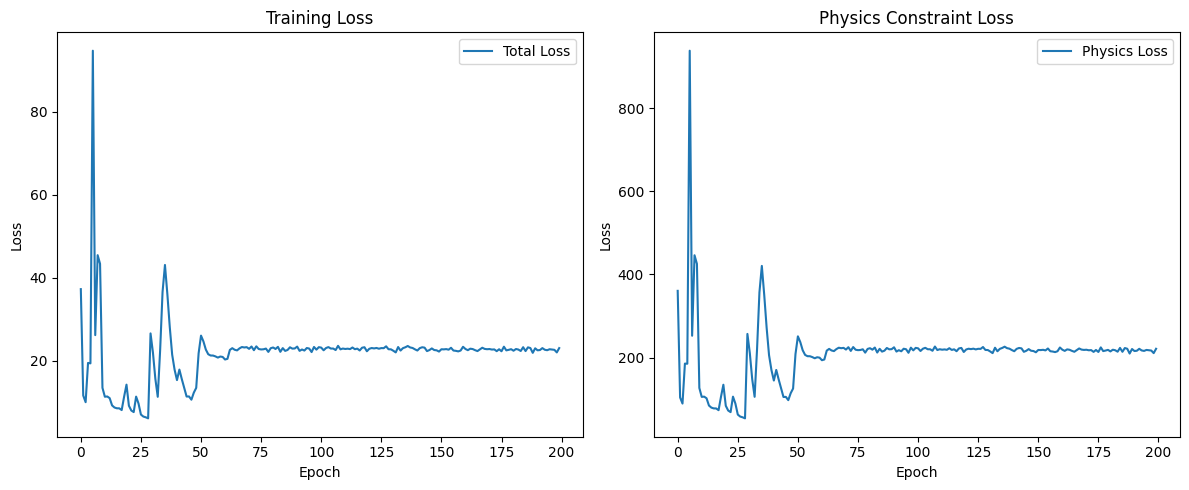


R² 分数:
G' (储能模量): 0.0022
G'' (损耗模量): 0.1041


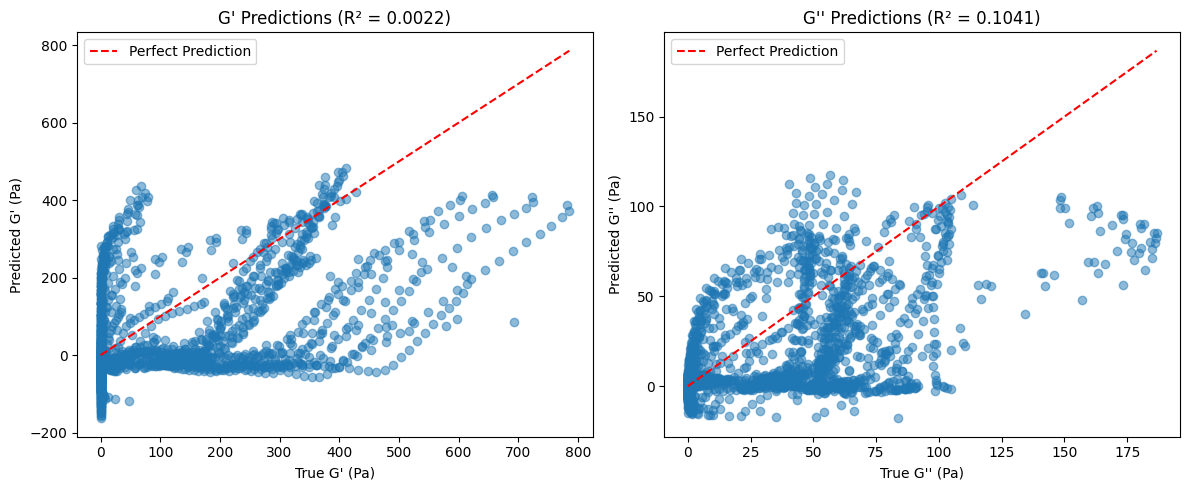

In [14]:
# 绘制损失曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(physics_losses, label='Physics Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Physics Constraint Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 加载最佳模型
model.load_state_dict(best_model_state)

# 模型评估
model.eval()
with torch.no_grad():
    test_predictions = model(X_tensor)
    
# 将预测结果转换回原始尺度
predictions = scaler_y.inverse_transform(test_predictions.cpu().numpy())
true_values = scaler_y.inverse_transform(y)

# 计算R²分数
from sklearn.metrics import r2_score
r2_g1 = r2_score(true_values[:, 0], predictions[:, 0])
r2_g2 = r2_score(true_values[:, 1], predictions[:, 1])

print(f"\nR² 分数:")
print(f"G' (储能模量): {r2_g1:.4f}")
print(f"G'' (损耗模量): {r2_g2:.4f}")

# 绘制预测 vs 实际值的散点图
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(true_values[:, 0], predictions[:, 0], alpha=0.5)
plt.plot([true_values[:, 0].min(), true_values[:, 0].max()], 
         [true_values[:, 0].min(), true_values[:, 0].max()], 
         'r--', label='Perfect Prediction')
plt.xlabel('True G\' (Pa)')
plt.ylabel('Predicted G\' (Pa)')
plt.title(f'G\' Predictions (R² = {r2_g1:.4f})')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(true_values[:, 1], predictions[:, 1], alpha=0.5)
plt.plot([true_values[:, 1].min(), true_values[:, 1].max()], 
         [true_values[:, 1].min(), true_values[:, 1].max()], 
         'r--', label='Perfect Prediction')
plt.xlabel('True G\'\' (Pa)')
plt.ylabel('Predicted G\'\' (Pa)')
plt.title(f'G\'\' Predictions (R² = {r2_g2:.4f})')
plt.legend()

plt.tight_layout()
plt.show()

# 流变性能预测模型 - 基于RandomForest的自定义版本

基于基线版本v2的修改：
1. 调整了异常数据的权重（tan_delta > 1000 时权重为0.01）
2. 增加了特征重要性分析
3. 添加了温度交互特征
4. 增加了预测结果的可视化

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
df = pd.read_csv("PB_Data.csv")

# 基本数据检查
required_cols = ['Sample_ID','Length_nm','Width_nm','Temp_C','Freq_rad_s','G1_Pa','G2_Pa']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# 数据类型转换
for col in ['Length_nm','Width_nm','Temp_C','Freq_rad_s','G1_Pa','G2_Pa']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 删除关键列中的NaN值
df = df.dropna(subset=required_cols)

# 计算tan_delta并设置权重
df['tan_delta'] = df['G2_Pa'] / df['G1_Pa']
df['flag_suspicious'] = df['tan_delta'] > 1000
df['sample_weight'] = np.where(df['flag_suspicious'], 0.01, 1.0)  # 修改为0.01

# 保存处理后的数据
df.to_csv('PB_Data_filtered.csv', index=False)
print("已保存处理后的数据到 PB_Data_filtered.csv")

print(f"\n数据统计：")
print(f"总样本数: {len(df)}")
print(f"异常样本数 (tan_delta > 1000): {df['flag_suspicious'].sum()}")
print(f"唯一Sample_ID数量: {df['Sample_ID'].nunique()}")
print("\n温度分布:")
print(df['Temp_C'].value_counts().sort_index())

# 显示异常样本的详细信息
print("\n异常样本 (tan_delta > 1000) 的详细信息:")
suspicious_samples = df[df['flag_suspicious']].sort_values('tan_delta', ascending=False)
print(suspicious_samples[['Sample_ID', 'Length_nm', 'Width_nm', 'Temp_C', 'Freq_rad_s', 'G1_Pa', 'G2_Pa', 'tan_delta']])

已保存处理后的数据到 PB_Data_filtered.csv

数据统计：
总样本数: 1875
异常样本数 (tan_delta > 1000): 161
唯一Sample_ID数量: 15

温度分布:
Temp_C
15    375
20    375
25    375
30    375
35    375
Name: count, dtype: int64

异常样本 (tan_delta > 1000) 的详细信息:
     Sample_ID  Length_nm  Width_nm  Temp_C  Freq_rad_s     G1_Pa     G2_Pa  \
1562      356C        300     17.61      25      1.0000  0.000011  0.214990   
233       409B         30     26.28      35      0.2150  0.000010  0.208730   
125       409B         30     26.28      15      0.0100  0.000002  0.037485   
16        409A         30     22.20      15      4.6400  0.000021  0.410910   
32        409A         30     22.20      20      0.1470  0.000001  0.028045   
...        ...        ...       ...     ...         ...       ...       ...   
55        409A         30     22.20      25      0.0681  0.000002  0.034107   
1616      356C        300     17.61      35      4.6400  0.000013  0.267240   
65        409A         30     22.20      25      3.1600  0.000015  0.

In [21]:
# 特征工程
df['Aspect'] = df['Length_nm'] / df['Width_nm']
df['log10_freq'] = np.log10(df['Freq_rad_s'])
df['log10_Gp'] = np.log10(df['G1_Pa'])
df['log10_Gpp'] = np.log10(df['G2_Pa'])
df['T_x_logf'] = df['Temp_C'] * df['log10_freq']
df['T_x_aspect'] = df['Temp_C'] * df['Aspect']  # 新增温度与长宽比的交互特征

feature_cols = ['Length_nm', 'Width_nm', 'Aspect', 'Temp_C', 
                'log10_freq', 'T_x_logf', 'T_x_aspect']
target_cols = ['log10_Gp', 'log10_Gpp']

X = df[feature_cols].values
y = df[target_cols].values
groups = df['Sample_ID'].values
weights = df['sample_weight'].values

# 构建模型管道
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MultiOutputRegressor(RandomForestRegressor(
        n_estimators=500,  # 增加树的数量
        max_depth=15,      # 限制树的深度以防过拟合
        min_samples_leaf=3,# 每个叶节点最少样本数
        random_state=42,
        n_jobs=-1
    )))
])

# 使用GroupKFold进行交叉验证
gkf = GroupKFold(n_splits=5)
cv_metrics = []

for fold, (train_idx, valid_idx) in enumerate(gkf.split(X, y, groups), 1):
    X_tr, X_va = X[train_idx], X[valid_idx]
    y_tr, y_va = y[train_idx], y[valid_idx]
    w_tr = weights[train_idx]
    
    pipe.fit(X_tr, y_tr, model__sample_weight=w_tr)
    y_pred = pipe.predict(X_va)
    
    # 计算评估指标
    metrics = {
        'fold': fold,
        'MAE_log10_Gp': mean_absolute_error(y_va[:,0], y_pred[:,0]),
        'MAE_log10_Gpp': mean_absolute_error(y_va[:,1], y_pred[:,1]),
        'R2_log10_Gp': r2_score(y_va[:,0], y_pred[:,0]),
        'R2_log10_Gpp': r2_score(y_va[:,1], y_pred[:,1])
    }
    cv_metrics.append(metrics)

cv_df = pd.DataFrame(cv_metrics)
print("\n交叉验证结果:")
print(cv_df.mean())


交叉验证结果:
fold             3.000000
MAE_log10_Gp     1.255055
MAE_log10_Gpp    0.824139
R2_log10_Gp      0.187822
R2_log10_Gpp     0.094361
dtype: float64


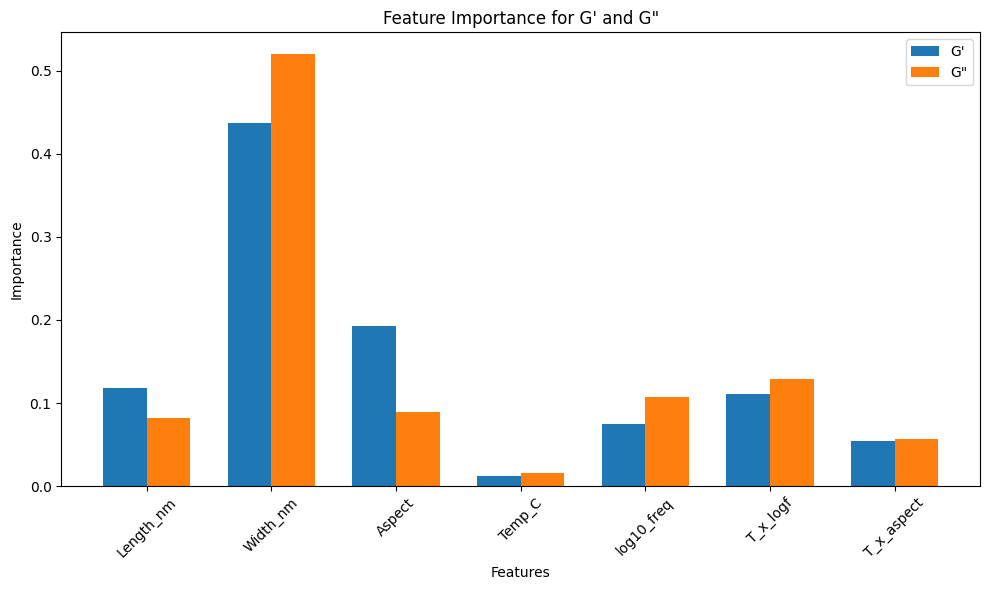


特征重要性排序:
      Feature  Importance_Gp  Importance_Gpp
1    Width_nm       0.436768        0.519953
2      Aspect       0.193126        0.089010
0   Length_nm       0.118130        0.081601
5    T_x_logf       0.110342        0.128680
4  log10_freq       0.075146        0.107806
6  T_x_aspect       0.054326        0.057331
3      Temp_C       0.012162        0.015619


In [22]:
# 特征重要性分析
pipe.fit(X, y, model__sample_weight=weights)
rf_model = pipe.named_steps['model']

# 获取每个目标的特征重要性
importance_gp = rf_model.estimators_[0].feature_importances_
importance_gpp = rf_model.estimators_[1].feature_importances_

# 创建特征重要性数据框
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance_Gp': importance_gp,
    'Importance_Gpp': importance_gpp
})

# 可视化特征重要性
plt.figure(figsize=(10, 6))
x = np.arange(len(feature_cols))
width = 0.35

plt.bar(x - width/2, importance_gp, width, label="G'")
plt.bar(x + width/2, importance_gpp, width, label='G"')
plt.xticks(x, feature_cols, rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance for G\' and G"')
plt.legend()
plt.tight_layout()
plt.show()

print("\n特征重要性排序:")
print(importance_df.sort_values('Importance_Gp', ascending=False))

In [23]:
# 预测新样本的函数
def predict_rheology(sample_data):
    """
    预测新样本的流变性能
    
    参数:
    sample_data: DataFrame，包含 Sample_ID, Length_nm, Width_nm, Temp_C, Freq_rad_s
    
    返回:
    DataFrame，包含预测结果和不确定性估计
    """
    # 特征工程
    sample_data['Aspect'] = sample_data['Length_nm'] / sample_data['Width_nm']
    sample_data['log10_freq'] = np.log10(sample_data['Freq_rad_s'])
    sample_data['T_x_logf'] = sample_data['Temp_C'] * sample_data['log10_freq']
    sample_data['T_x_aspect'] = sample_data['Temp_C'] * sample_data['Aspect']
    
    # 准备特征
    X_new = sample_data[feature_cols].values
    
    # 预测
    y_pred_log = pipe.predict(X_new)
    y_pred = 10**y_pred_log
    
    # 准备输出
    results = sample_data.copy()
    results['G1_Pa_pred'] = y_pred[:,0]
    results['G2_Pa_pred'] = y_pred[:,1]
    results['tan_delta_pred'] = results['G2_Pa_pred'] / results['G1_Pa_pred']
    
    return results

# 示例：预测新样本
new_samples = pd.DataFrame({
     "Sample_ID": ["411c","411c","411c","411c","411c","411c","411c","411c","411c","411c","411c","411c","411c","411c","411c"],
    "Length_nm": [300,300,300,300,300,300,300,300,300,300,300,300,300,300,300],
    "Width_nm": [20.94,20.94,20.94,20.94,20.94,20.94,20.94,20.94,20.94,20.94,20.94,20.94,20.94,20.94,20.94],
    "Temp_C": [25,25,25,25,25,25,25,25,25,25,25,25,25,25,25],
    "Freq_rad_s": [0.1, 0.127, 0.161, 0.204, 0.53, 1.08, 1.74, 2.81, 4.52, 9.24, 14.9, 24, 48.9, 78.8, 100],
})
predictions = predict_rheology(new_samples)
print("\n新样本预测结果:")
print(predictions[['Sample_ID', 'Length_nm', 'Width_nm', 'Temp_C', 
                  'Freq_rad_s', 'G1_Pa_pred', 'G2_Pa_pred', 'tan_delta_pred']])


新样本预测结果:
   Sample_ID  Length_nm  Width_nm  Temp_C  Freq_rad_s  G1_Pa_pred  G2_Pa_pred  \
0       411c        300     20.94      25       0.100    0.113039    0.639191   
1       411c        300     20.94      25       0.127    0.118042    0.638470   
2       411c        300     20.94      25       0.161    0.112381    0.651858   
3       411c        300     20.94      25       0.204    0.124025    0.749770   
4       411c        300     20.94      25       0.530    0.256191    1.052005   
5       411c        300     20.94      25       1.080    0.187470    1.536400   
6       411c        300     20.94      25       1.740    0.225348    2.069622   
7       411c        300     20.94      25       2.810    0.374108    3.179615   
8       411c        300     20.94      25       4.520    0.548199    4.291910   
9       411c        300     20.94      25       9.240    0.589387    6.509347   
10      411c        300     20.94      25      14.900    0.312584    9.916150   
11      411c      

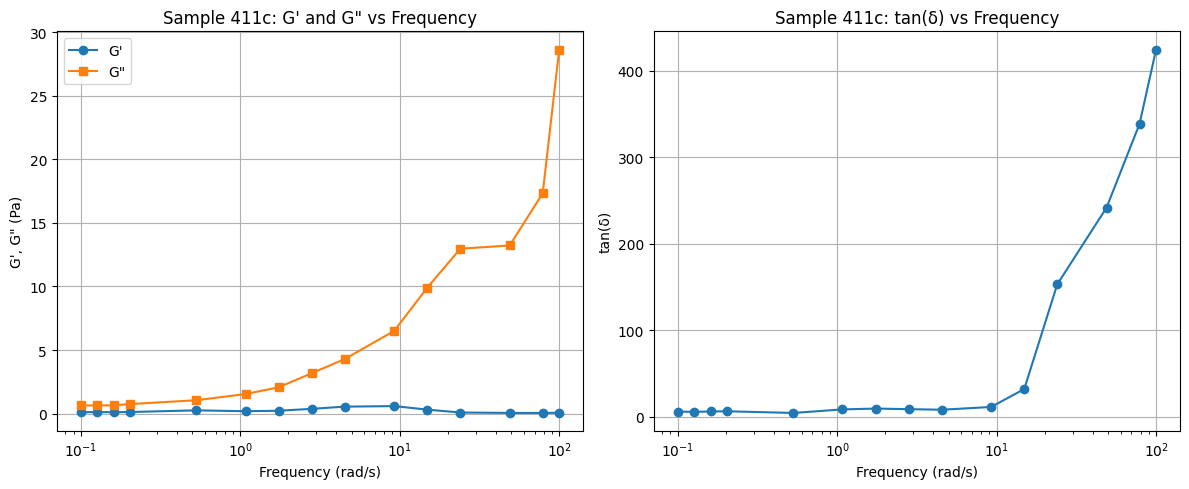

In [19]:
# 预测结果可视化
def plot_predictions(predictions, sample_id):
    sample_data = predictions[predictions['Sample_ID'] == sample_id]
    
    plt.figure(figsize=(12, 5))
    
    # G' 和 G" 随频率的变化
    plt.subplot(1, 2, 1)
    plt.semilogx(sample_data['Freq_rad_s'], sample_data['G1_Pa_pred'], 'o-', label="G'")
    plt.semilogx(sample_data['Freq_rad_s'], sample_data['G2_Pa_pred'], 's-', label='G"')
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('G\', G" (Pa)')
    plt.title(f'Sample {sample_id}: G\' and G" vs Frequency')
    plt.legend()
    plt.grid(True)
    
    # tan_delta 随频率的变化
    plt.subplot(1, 2, 2)
    plt.semilogx(sample_data['Freq_rad_s'], sample_data['tan_delta_pred'], 'o-')
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('tan(δ)')
    plt.title(f'Sample {sample_id}: tan(δ) vs Frequency')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 为每个新样本绘制预测结果
for sample_id in predictions['Sample_ID'].unique():
    plot_predictions(predictions, sample_id)

## 使用说明

1. 数据要求：
   - 输入数据必须包含：Sample_ID, Length_nm, Width_nm, Temp_C, Freq_rad_s
   - G1_Pa (G') 和 G2_Pa (G") 为预测目标
   - tan_delta = G2_Pa / G1_Pa 用于数据质量控制

2. 模型特点：
   - 使用RandomForest进行多输出回归
   - 对异常数据(tan_delta > 1000)使用0.01的权重
   - 按Sample_ID分组进行交叉验证
   - 包含特征重要性分析
   
3. 预测功能：
   - 使用predict_rheology函数进行预测
   - 可视化函数用于展示预测结果
   
4. 评估指标：
   - MAE和R2分数（对数空间）
   - 交叉验证确保模型稳定性